In [1]:
import cv2
import mediapipe as mp
import numpy as np
from IPython.display import clear_output, display, Image


In [2]:
def calculate_angle(a, b, c):
    """Calculate the angle (in degrees) at point b formed by points a, b, and c."""
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    
    ba = a - b
    bc = c - b
    
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.degrees(np.arccos(cosine_angle))
    
    return min(angle, 360 - angle)


In [3]:
# ----------------- Video and Pose Setup -----------------
video_path = "hamstring_flexibility.mp4"
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
if fps <= 0: fps = 30.0

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

# ----------------- Tracking Variables -----------------
max_angles = {'AKH': 0, 'KHS': 180}
peak_flexibility = {'AKH': 0, 'KHS': 180}



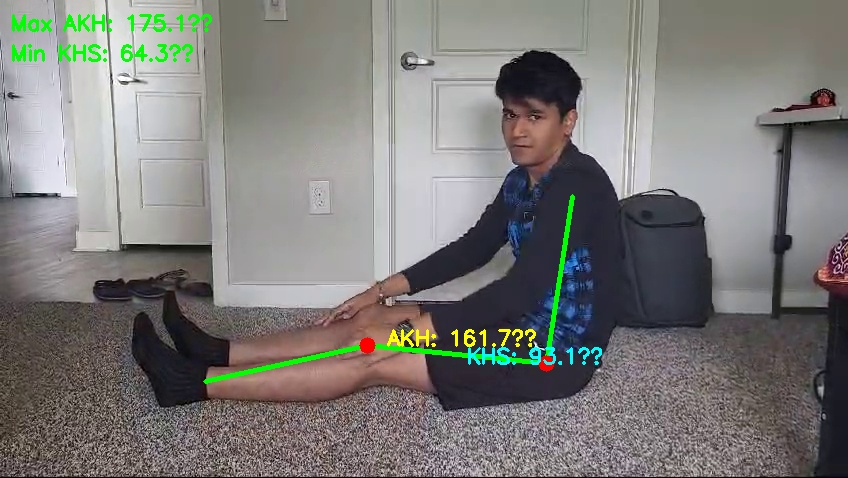

In [4]:
# ----------------- Processing Loop -----------------
while cap.isOpened():
    ret, frame = cap.read()
    if not ret: break

    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)
    image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)
    h, w, _ = image.shape

    if results.pose_landmarks:
        landmarks = results.pose_landmarks.landmark
        
        # Left side landmarks
        la = (int(landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].x * w),
              int(landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].y * h))
        lk = (int(landmarks[mp_pose.PoseLandmark.LEFT_KNEE].x * w),
              int(landmarks[mp_pose.PoseLandmark.LEFT_KNEE].y * h))
        lh = (int(landmarks[mp_pose.PoseLandmark.LEFT_HIP].x * w),
              int(landmarks[mp_pose.PoseLandmark.LEFT_HIP].y * h))
        ls = (int(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x * w),
              int(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y * h))

        # Visual connections
        cv2.line(image, la, lk, (0,255,0), 3)  # Ankle to knee
        cv2.line(image, lk, lh, (0,255,0), 3)  # Knee to hip
        cv2.line(image, lh, ls, (0,255,0), 3)  # Hip to shoulder
        cv2.circle(image, lk, 8, (0,0,255), -1)  # Knee joint
        cv2.circle(image, lh, 8, (0,0,255), -1)  # Hip joint

        # Calculate angles
        akh_angle = calculate_angle(la, lk, lh)
        khs_angle = calculate_angle(lk, lh, ls)

        # Update max angles
        max_angles['AKH'] = max(max_angles['AKH'], akh_angle)
        max_angles['KHS'] = min(max_angles['KHS'], khs_angle)

        # Real-time annotations
        cv2.putText(image, f"AKH: {akh_angle:.1f}°", 
                   (lk[0]+20, lk[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,255), 2)
        cv2.putText(image, f"KHS: {khs_angle:.1f}°", 
                   (lh[0]-80, lh[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,0), 2)
        cv2.putText(image, f"Max AKH: {max_angles['AKH']:.1f}°", 
                   (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)
        cv2.putText(image, f"Min KHS: {max_angles['KHS']:.1f}°", 
                   (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)

    # Display frame
    ret2, buffer = cv2.imencode('.jpg', image)
    if ret2:
        clear_output(wait=True)
        display(Image(data=buffer.tobytes()))

cap.release()


In [5]:
# ----------------- Comprehensive Analysis -----------------
analysis = [
    ("Ankle-Knee-Hip (AKH)", max_angles['AKH'], 180, 170,
    "Knee extension angle - higher values indicate better hamstring flexibility"),
    
    ("Knee-Hip-Shoulder (KHS)", max_angles['KHS'], 40, 55,
    "Spinal flexion angle - lower values indicate better forward reach")
]

print("╔══════════════════════════════════════════════════╗")
print("║           HAMSTRING FLEXIBILITY ANALYSIS         ║")
print("╠══════════════════════════╦═════════╦═════════════╣")
print("║        Measurement       ║  Angle  ║  Status     ║")
print("╠══════════════════════════╬═════════╬═════════════╣")

for name, value, good, better, note in analysis:
    if "AKH" in name:
        status = "Excellent" if value >= 175 else "Good" if value >= 165 else "Needs Work"
    else:
        status = "Excellent" if value <= 45 else "Good" if value <= 55 else "Needs Work"
    
    print(f"║ {name:24} ║ {value:6.1f}° ║ {status:11} ║")
    print(f"║ {'Note: ' + note:47} ║")
    print("╠══════════════════════════╬═════════╬═════════════╣")

print("╚══════════════════════════╩═════════╩═════════════╝")
print("\nRecommendations:")
if max_angles['AKH'] < 170:
    print("- Perform daily hamstring stretches (seated reach & standing toe touches)")
if max_angles['KHS'] > 50:
    print("- Improve spinal flexibility with cat-cow stretches and forward folds")
if max_angles['AKH'] >= 175 and max_angles['KHS'] <= 45:
    print("- Maintain flexibility with yoga poses (downward dog & pyramid pose)")


╔══════════════════════════════════════════════════╗
║           HAMSTRING FLEXIBILITY ANALYSIS         ║
╠══════════════════════════╦═════════╦═════════════╣
║        Measurement       ║  Angle  ║  Status     ║
╠══════════════════════════╬═════════╬═════════════╣
║ Ankle-Knee-Hip (AKH)     ║  175.1° ║ Excellent   ║
║ Note: Knee extension angle - higher values indicate better hamstring flexibility ║
╠══════════════════════════╬═════════╬═════════════╣
║ Knee-Hip-Shoulder (KHS)  ║   64.3° ║ Needs Work  ║
║ Note: Spinal flexion angle - lower values indicate better forward reach ║
╠══════════════════════════╬═════════╬═════════════╣
╚══════════════════════════╩═════════╩═════════════╝

Recommendations:
- Improve spinal flexibility with cat-cow stretches and forward folds
